In [1]:
# change the saving path
exp_name = "horseandzebra"
exp_details = "experiment for horser and zebr swapping, date: 3/9/19 "

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_small_xian as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_AE_128FC import DAE
#from models.model_AE_VGG16 import AE_VGG16

from random import randint
os.environ["CUDA_VISIBLE_DEVICES"] = "5, 6"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
print("Torch Version: {}".format(torch.__version__))
print("Cuda Available: {} \t device Count: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))

Torch Version: 1.0.1.post2
Cuda Available: True 	 device Count: 2


In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
cuda = torch.cuda.is_available()
save_path = 'Experiments/' + exp_name
if not os.path.isdir(save_path):
    os.makedirs(save_path)
    os.makedirs(save_path + '/weight')
    os.makedirs(save_path + '/images')

In [4]:
datasets

<module 'torchvision.datasets' from '/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/datasets/__init__.py'>

In [5]:
mycoco.CocoDetection?


Init signature:
mycoco.CocoDetection(
    root,
    annFile,
    transform=None,
    target_transform=None,
    categories=None,
    batch_size=32,
    transition=False,
)
Docstring:     
`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /nfs/eecs-fserv/share/linzhe/CS535Proj/TestExamples/AutoEncoder/mycoco_small_xian.py
Type:           type
Subclasses:     


In [6]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['horse', 'zebra'],transition = True)
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [7]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)
len(cocoDataset)

loading annotations into memory...
Done (t=16.23s)
creating index...
index created!


265

In [8]:
# check that there exist 10 different classes
np.unique(cocoDataset.categories)

array(['horse', 'zebra'], dtype='<U5')

torch.Size([64, 3, 224, 224])
(224, 224, 3)


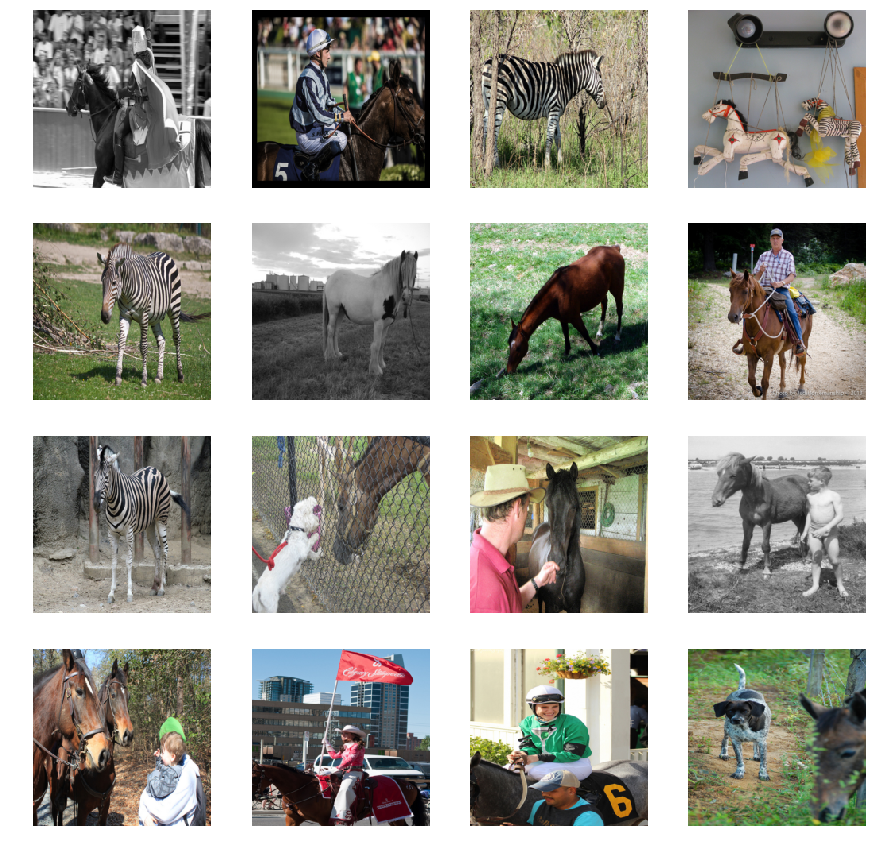

In [9]:
for im, mask, obj, _, _ in cocoloader:
    print(im.shape)
    print(np.swapaxes(np.swapaxes(im[0].numpy(),0,1),1,2).shape)
    break
    


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask, obj, _, _ in  cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

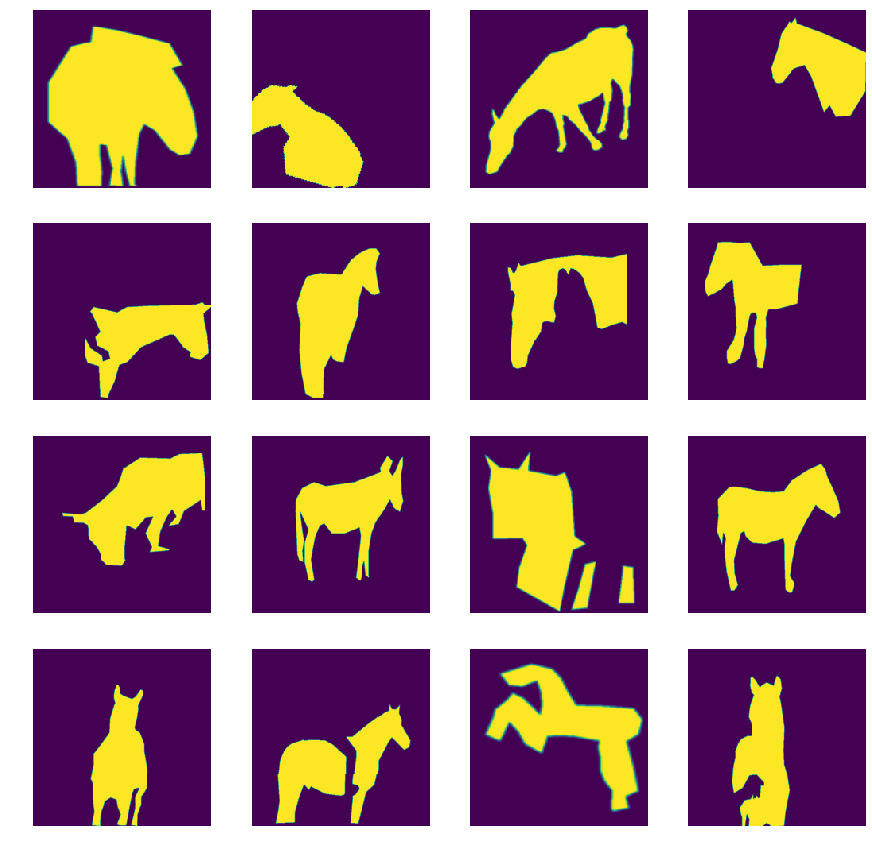

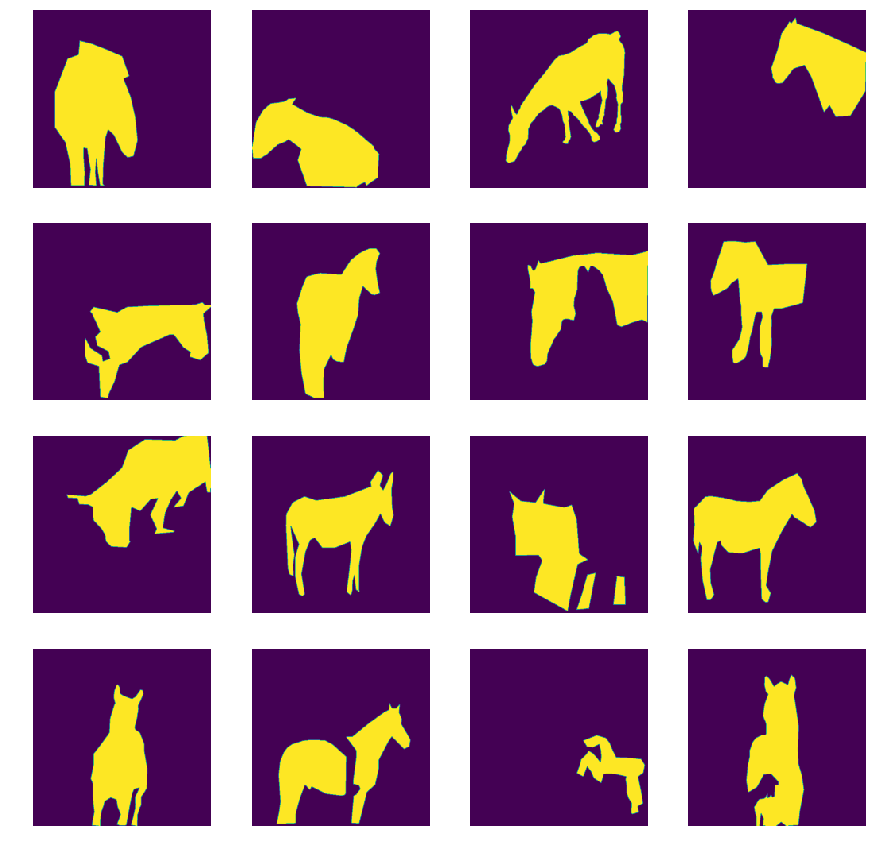

In [10]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2, axarr2 = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f2.subplots_adjust()
i = 0
j = 0
'''
mask_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()
                                       ])
'''

for im, masks, obj, mask_trans, obj_trans in  cocoloader:
    
    for mask, mask_tran in zip(masks, mask_trans):

        axarr[i, j].imshow(mask_tran.numpy()[0])
        axarr[i, j].axis('off')
        
        axarr2[i, j].imshow(mask.numpy()[0])
        axarr2[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

In [11]:

print(np.where(np.array([0,1,1,0,1,0, 1]))[0][[0, -1]])

[1 6]


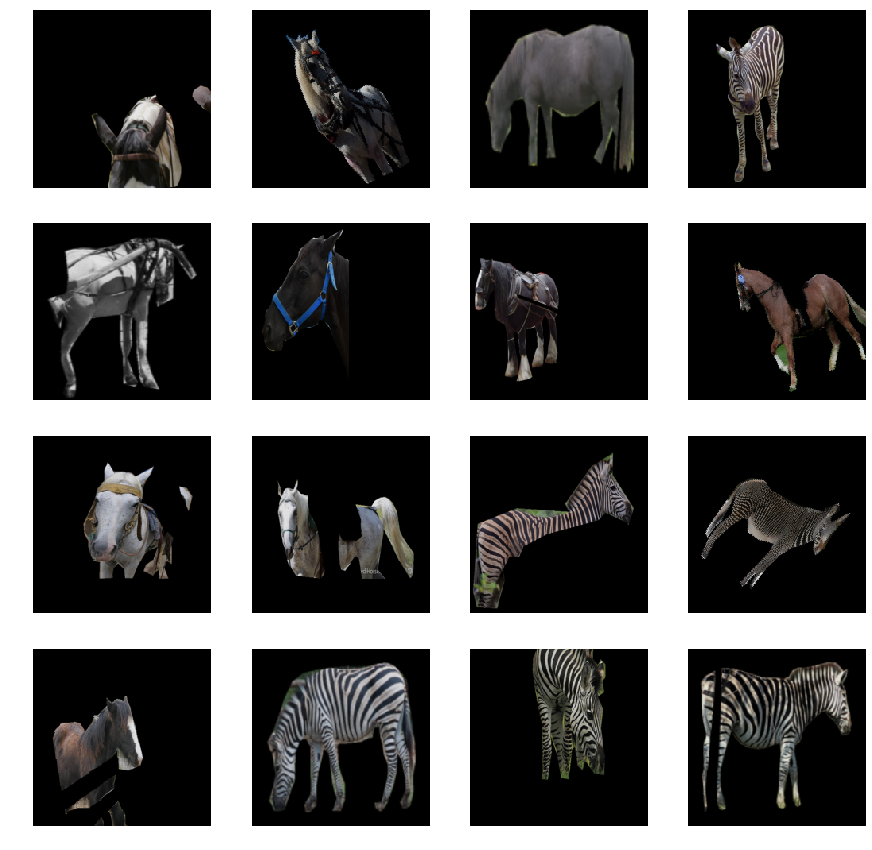

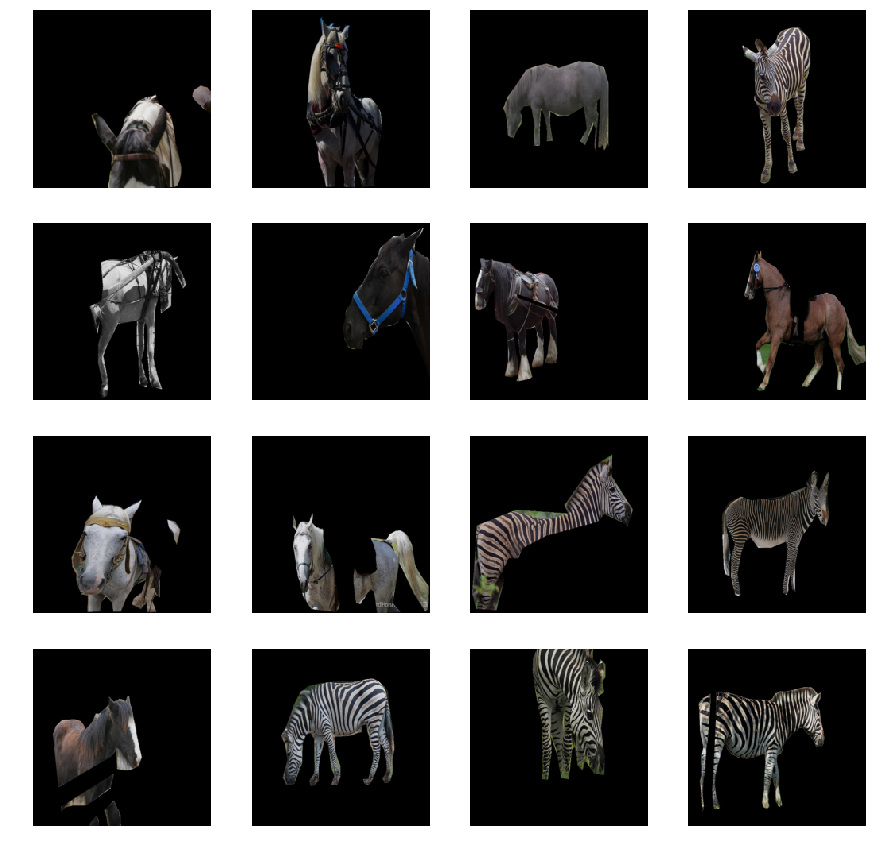

In [12]:


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2, axarr2 = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2.subplots_adjust()
i = 0
j = 0

    
obj_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()
                                       ])

for im, masks, objs, mask_trans, obj_trans in  cocoloader:
    
    for obj, obj_tran in zip(objs, obj_trans):
        
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(obj_tran.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        
        axarr2[i, j].imshow(np.swapaxes(np.swapaxes(obj.numpy(),0,1),1,2))
        axarr2[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

In [13]:

data_loader = cocoloader
# pin_memory if you're on GPU

In [14]:
from torch import nn

In [15]:
n_batches = int(np.ceil(len(cocoDataset)/ BATCH_SIZE)) # 60000 / 100

In [16]:
n_batches

5

In [17]:
n_batches


5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


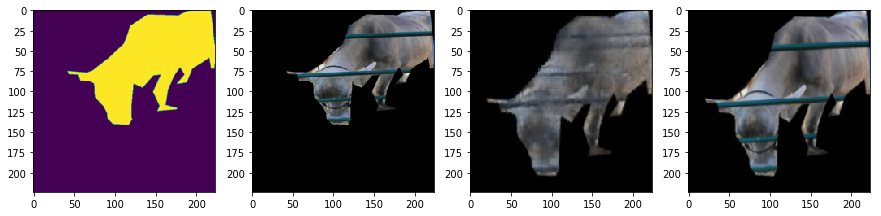

Epoch [20000/20000], Step[5/5], d_loss: 0.0071, g_loss: 0.0071, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20010/20000], Step[5/5], d_loss: 0.0069, g_loss: 0.0069, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20020/20000], Step[5/5], d_loss: 0.0062, g_loss: 0.0062, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20030/20000], Step[5/5], d_loss: 0.0058, g_loss: 0.0058, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20040/20000], Step[5/5], d_loss: 0.0084, g_loss: 0.0084, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20050/20000], Step[5/5], d_loss: 0.0054, g_loss: 0.0054, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20060/20000], Step[5/5], d_loss: 0.0057, g_loss: 0.0057, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20070/20000], Step[5/5], d_loss: 0.0054, g_loss: 0.0054, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20080/20000], Step[5/5], d_loss: 0.0076, g_loss: 0.0076, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20090/20000], Step[5/5], d_loss: 0.0111, g_loss: 0.0111, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


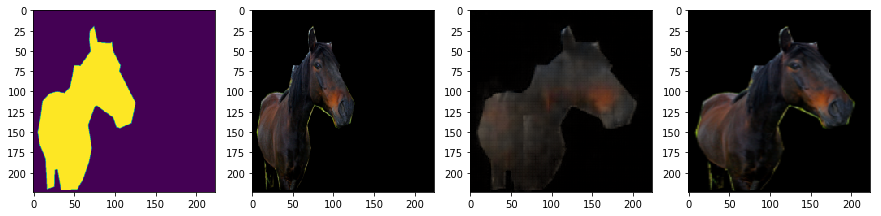

Epoch [20100/20000], Step[5/5], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20110/20000], Step[5/5], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20120/20000], Step[5/5], d_loss: 0.0050, g_loss: 0.0050, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20130/20000], Step[5/5], d_loss: 0.0079, g_loss: 0.0079, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20140/20000], Step[5/5], d_loss: 0.0065, g_loss: 0.0065, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20150/20000], Step[5/5], d_loss: 0.0040, g_loss: 0.0040, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20160/20000], Step[5/5], d_loss: 0.0058, g_loss: 0.0058, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20170/20000], Step[5/5], d_loss: 0.0052, g_loss: 0.0052, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20180/20000], Step[5/5], d_loss: 0.0073, g_loss: 0.0073, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20190/20000], Step[5/5], d_loss: 0.0068, g_loss: 0.0068, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


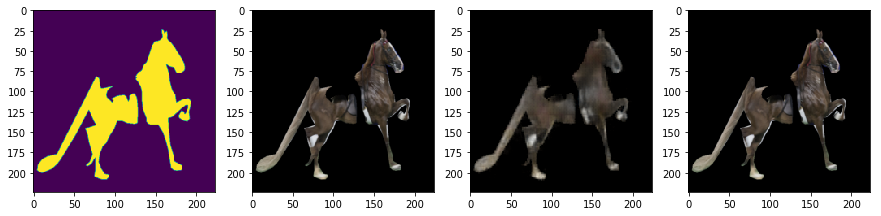

Epoch [20200/20000], Step[5/5], d_loss: 0.0109, g_loss: 0.0109, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20210/20000], Step[5/5], d_loss: 0.0097, g_loss: 0.0097, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20220/20000], Step[5/5], d_loss: 0.0068, g_loss: 0.0068, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20230/20000], Step[5/5], d_loss: 0.0067, g_loss: 0.0067, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20240/20000], Step[5/5], d_loss: 0.0060, g_loss: 0.0060, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20250/20000], Step[5/5], d_loss: 0.0078, g_loss: 0.0078, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20260/20000], Step[5/5], d_loss: 0.0080, g_loss: 0.0080, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20270/20000], Step[5/5], d_loss: 0.0061, g_loss: 0.0061, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20280/20000], Step[5/5], d_loss: 0.0103, g_loss: 0.0103, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20290/20000], Step[5/5], d_loss: 0.0060, g_loss: 0.0060, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


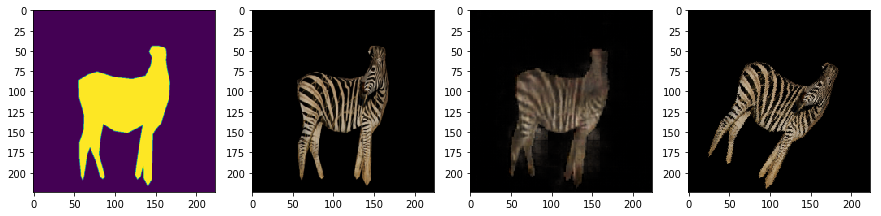

Epoch [20300/20000], Step[5/5], d_loss: 0.0074, g_loss: 0.0074, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20310/20000], Step[5/5], d_loss: 0.0057, g_loss: 0.0057, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20320/20000], Step[5/5], d_loss: 0.0119, g_loss: 0.0119, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20330/20000], Step[5/5], d_loss: 0.0061, g_loss: 0.0061, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20340/20000], Step[5/5], d_loss: 0.0133, g_loss: 0.0133, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20350/20000], Step[5/5], d_loss: 0.0058, g_loss: 0.0058, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20360/20000], Step[5/5], d_loss: 0.0101, g_loss: 0.0101, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20370/20000], Step[5/5], d_loss: 0.0072, g_loss: 0.0072, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20380/20000], Step[5/5], d_loss: 0.0078, g_loss: 0.0078, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20410/20000], Step[5/5], d_loss: 0.0035, g_loss: 0.0035, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


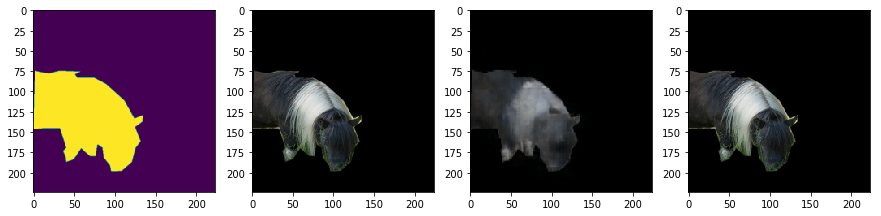

Epoch [20500/20000], Step[5/5], d_loss: 0.0076, g_loss: 0.0076, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20510/20000], Step[5/5], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20520/20000], Step[5/5], d_loss: 0.0073, g_loss: 0.0073, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20530/20000], Step[5/5], d_loss: 0.0097, g_loss: 0.0097, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20540/20000], Step[5/5], d_loss: 0.0036, g_loss: 0.0036, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20550/20000], Step[5/5], d_loss: 0.0084, g_loss: 0.0084, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20560/20000], Step[5/5], d_loss: 0.0057, g_loss: 0.0057, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20570/20000], Step[5/5], d_loss: 0.0105, g_loss: 0.0105, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20580/20000], Step[5/5], d_loss: 0.0056, g_loss: 0.0056, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20590/20000], Step[5/5], d_loss: 0.0057, g_loss: 0.0057, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


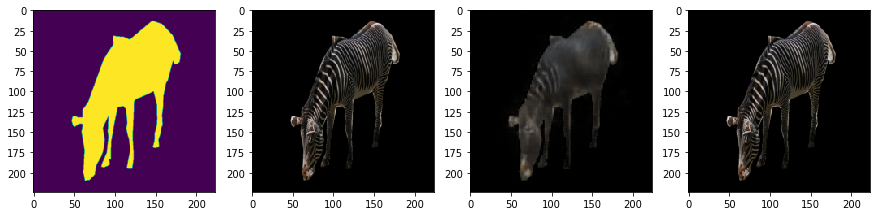

Epoch [20600/20000], Step[5/5], d_loss: 0.0045, g_loss: 0.0045, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20610/20000], Step[5/5], d_loss: 0.0072, g_loss: 0.0072, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20620/20000], Step[5/5], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20630/20000], Step[5/5], d_loss: 0.0087, g_loss: 0.0087, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20640/20000], Step[5/5], d_loss: 0.0060, g_loss: 0.0060, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20650/20000], Step[5/5], d_loss: 0.0041, g_loss: 0.0041, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20660/20000], Step[5/5], d_loss: 0.0064, g_loss: 0.0064, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20670/20000], Step[5/5], d_loss: 0.0062, g_loss: 0.0062, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20680/20000], Step[5/5], d_loss: 0.0074, g_loss: 0.0074, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20690/20000], Step[5/5], d_loss: 0.0059, g_loss: 0.0059, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


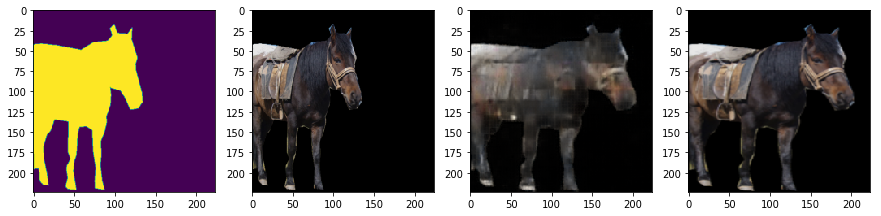

Epoch [20700/20000], Step[5/5], d_loss: 0.0072, g_loss: 0.0072, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20710/20000], Step[5/5], d_loss: 0.0074, g_loss: 0.0074, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20720/20000], Step[5/5], d_loss: 0.0061, g_loss: 0.0061, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20730/20000], Step[5/5], d_loss: 0.0076, g_loss: 0.0076, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20740/20000], Step[5/5], d_loss: 0.0054, g_loss: 0.0054, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20750/20000], Step[5/5], d_loss: 0.0059, g_loss: 0.0059, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20760/20000], Step[5/5], d_loss: 0.0064, g_loss: 0.0064, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20770/20000], Step[5/5], d_loss: 0.0091, g_loss: 0.0091, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20780/20000], Step[5/5], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20790/20000], Step[5/5], d_loss: 0.0080, g_loss: 0.0080, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


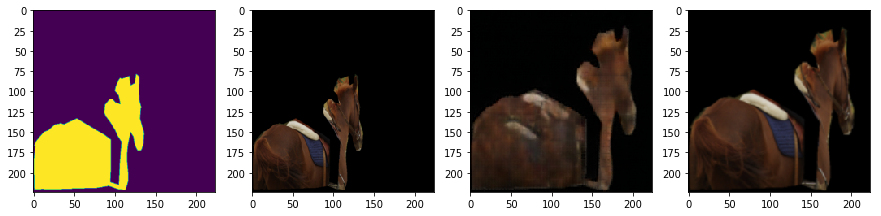

Epoch [20800/20000], Step[5/5], d_loss: 0.0055, g_loss: 0.0055, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20810/20000], Step[5/5], d_loss: 0.0093, g_loss: 0.0093, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20820/20000], Step[5/5], d_loss: 0.0070, g_loss: 0.0070, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20830/20000], Step[5/5], d_loss: 0.0097, g_loss: 0.0097, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20840/20000], Step[5/5], d_loss: 0.0106, g_loss: 0.0106, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20850/20000], Step[5/5], d_loss: 0.0045, g_loss: 0.0045, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20860/20000], Step[5/5], d_loss: 0.0082, g_loss: 0.0082, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20880/20000], Step[5/5], d_loss: 0.0089, g_loss: 0.0089, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20890/20000], Step[5/5], d_loss: 0.0055, g_loss: 0.0055, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


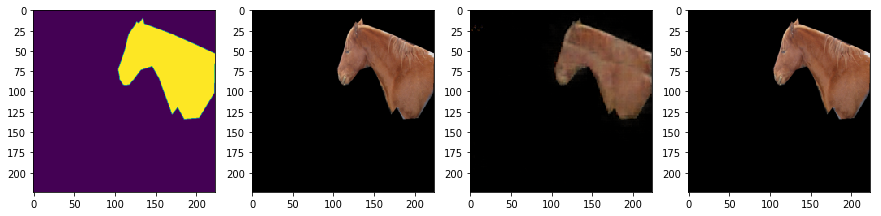

Epoch [20900/20000], Step[5/5], d_loss: 0.0071, g_loss: 0.0071, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20910/20000], Step[5/5], d_loss: 0.0097, g_loss: 0.0097, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20920/20000], Step[5/5], d_loss: 0.0034, g_loss: 0.0034, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20930/20000], Step[5/5], d_loss: 0.0063, g_loss: 0.0063, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20940/20000], Step[5/5], d_loss: 0.0084, g_loss: 0.0084, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20950/20000], Step[5/5], d_loss: 0.0075, g_loss: 0.0075, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20960/20000], Step[5/5], d_loss: 0.0096, g_loss: 0.0096, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20970/20000], Step[5/5], d_loss: 0.0057, g_loss: 0.0057, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20980/20000], Step[5/5], d_loss: 0.0081, g_loss: 0.0081, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20990/20000], Step[5/5], d_loss: 0.0068, g_loss: 0.0068, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


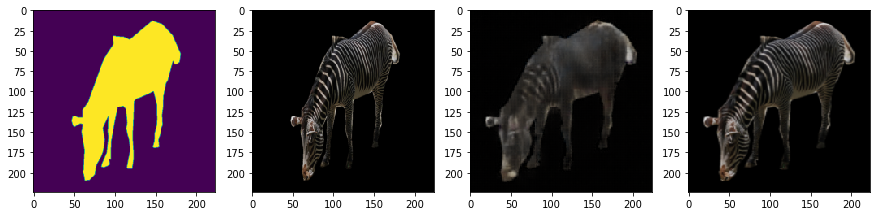

Epoch [21000/20000], Step[5/5], d_loss: 0.0067, g_loss: 0.0067, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21010/20000], Step[5/5], d_loss: 0.0076, g_loss: 0.0076, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21020/20000], Step[5/5], d_loss: 0.0117, g_loss: 0.0117, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21030/20000], Step[5/5], d_loss: 0.0042, g_loss: 0.0042, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21040/20000], Step[5/5], d_loss: 0.0080, g_loss: 0.0080, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21050/20000], Step[5/5], d_loss: 0.0062, g_loss: 0.0062, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21060/20000], Step[5/5], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21070/20000], Step[5/5], d_loss: 0.0094, g_loss: 0.0094, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21080/20000], Step[5/5], d_loss: 0.0075, g_loss: 0.0075, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21090/20000], Step[5/5], d_loss: 0.0097, g_loss: 0.0097, Mean D(x): 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


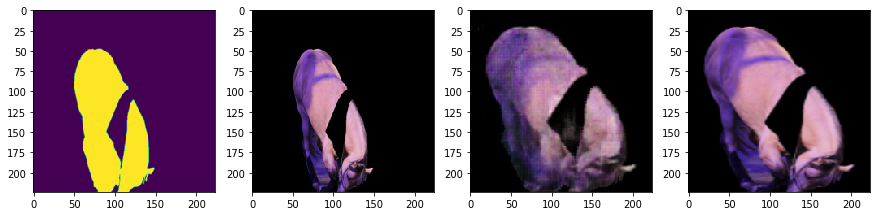

Epoch [21100/20000], Step[5/5], d_loss: 0.0056, g_loss: 0.0056, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21110/20000], Step[5/5], d_loss: 0.0063, g_loss: 0.0063, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21120/20000], Step[5/5], d_loss: 0.0053, g_loss: 0.0053, Mean D(x): 0.00, Mean D(G(z)): 0.00


In [ ]:
# dae = DAE(IMAGE_SIZE)
# dae.load_state_dict(torch.load('./weights_mask_trans/dae-500.pkl'))
from models.model_AE_VGG16_2 import AE_VGG16_2
ae_vgg16 = AE_VGG16_2(IMAGE_SIZE)
model = ae_vgg16
#model.load_state_dict(torch.load('./Experiments/horseandzebra/weight/last_weight.pkl'))
check_point_path = './Experiments/horseandzebra/weight/last_weight.pkl'
d2 =  {str(k)[7:]:v for k,v in torch.load(check_point_path).items()}
model.load_state_dict(d2)
if cuda:
    model.cuda()
model = nn.DataParallel(model)
num_epochs = 20000
model.batch_size = BATCH_SIZE
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
'''
f_result = open(save_path + '/weight/train_loss.txt', 'w')
f_result.close()
'''
for epoch in range(num_epochs + 1):
    f_result = open(save_path + '/weight/train_loss.txt', 'a')
    total_loss = 0
    epoch_start = True # quick hack
    epoch += 20000
    for I, (images, masks, objs, mask_trans, objs_trans) in enumerate(cocoloader):
        #target_imgs = np.zeros_like(images)
        #target_masks = np.zeros_like(masks)
        
        #images = np.multiply(images,masks)
        
        if cuda:
            images = Variable(images).cuda()
            masks = Variable(masks).cuda()
            objs = Variable(objs).cuda()
            mask_trans = Variable(mask_trans).cuda()
            objs_trans = Variable(objs_trans).cuda()
        else:
            images = Variable(images)
            masks = Variable(masks)
            objs = Variable(objs)
            mask_trans = Variable(mask_trans)
            objs_trans = Variable(objs_trans)
        '''    
        #transform all images in the batch with different transforms. 
        for i in range(x.shape[0]):
            rmin, rmax, cmin, cmax =  cocoDataset.bbox(masks[i][0].data.cpu().numpy())
            
            cx = randint(0 - cmin,  IMAGE_SIZE - cmax )
            ry = randint(0 - rmin,  IMAGE_SIZE - rmax )
            
            target_image = np.zeros((3,IMAGE_SIZE, IMAGE_SIZE))
            target_mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
            
            target_image[:,rmin + ry : rmax + ry, cmin + cx : cmax + cx] = images[i][:,rmin : rmax, cmin : cmax]
            target_mask[rmin + ry : rmax + ry, cmin + cx : cmax + cx] = masks[i][0][rmin : rmax, cmin : cmax].data.cpu().numpy()
            curr_img = images[i].data.cpu().numpy() * masks[i][0].data.cpu().numpy()
            tar_img = target_image * target_mask
            
            target_imgs[i] = tar_img
            target_masks[i][0] = target_mask
            #print(np.multiply(image,mask))
            #print(target_image)
#             if(epoch_start):
#                 f, axarr = plt.subplots(1, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size

#                 axarr[0].imshow(masks[i][0].data.cpu().numpy())
#                 axarr[1].imshow(target_mask)
#                 axarr[2].imshow(np.swapaxes(np.swapaxes(curr_img,0,1),1,2))
#                 axarr[3].imshow(np.swapaxes(np.swapaxes(tar_img,0,1),1,2))

#                 plt.show()
#                 epoch_start = False
#             break
#             input()
            #print(cx, ry)
        '''
#         if cuda:
#             target_imgs = Variable(torch.from_numpy(target_imgs)).cuda()
#             target_masks = Variable(torch.from_numpy(target_masks)).cuda()
#         else:
#             target_imgs = Variable(target_imgs)
#             target_masks = Variable(target_masks)
            
        optimizer.zero_grad()
        z, x_hat = model(objs, mask_trans)
        #print(x.shape, x_hat.shape)
        loss = criterion(x_hat, objs_trans)
        
        #quick hack 
        if(epoch_start and epoch%100 == 0):
            f, axarr = plt.subplots(1, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size

            axarr[0].imshow(masks[0][0].data.cpu().numpy())
            axarr[1].imshow(np.swapaxes(np.swapaxes(objs[0].data.cpu().numpy(),0,1),1,2))
            axarr[2].imshow(np.swapaxes(np.swapaxes(x_hat[0].data.cpu().numpy(),0,1),1,2))
            axarr[3].imshow(np.swapaxes(np.swapaxes(objs_trans[0].data.cpu().numpy(),0,1),1,2))

            plt.show()
#             pdb.set_trace()
            save_image(torch.cat((objs[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE),
                                  x_hat[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE),
                                  objs_trans[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE)), dim = 0)
                                   , save_path + '/images/fake_inside-%0.3d.png' %(epoch + 1))
            
            epoch_start = False

        loss.backward()
        optimizer.step()
        '''
        if (i + 1) % 1 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.data[0]))
            torch.save(dae.state_dict(), 'dae-test-model.pkl')
        '''
        total_loss += loss.item()
        if (I + 1) % n_batches == 0 and epoch % 10 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    num_epochs,
                    I + 1,
                    n_batches,
                    loss.data,
                    loss.data,
                    0,
                    0)
            )

    #Save the image
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
        save_image(images.data, save_path + '/images/real_images.png')
        
    fake_images = x_hat
    
    
    if(epoch%100 == 0):
        save_image(fake_images.data, save_path + '/images/fake_images-%0.3d.png' %(epoch + 1))
    #print(total_loss)
    
    f_result.write("Epoch: {}, train_loss: {}\n".format(epoch + 1, str(total_loss)))
    f_result.close()
    
    # Save the trained parameters 
    #if (epoch + 1) % 500 == 0:
    torch.save(model.state_dict(), save_path + '/weight/last_weight.pkl')
#     torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        

In [ ]:
a = torch.randn(2,2,3,3)
b = torch.randn(2,1,3,3)
print(a)
print(b)
c = torch.cat((a, b), dim = 1)
print(c)
print(a.shape, c.shape)


In [ ]:
dae = DAE()
#dae.load('weights_mask/dae-999.pkl')
dae.load_state_dict(torch.load('weights_mask/dae-951.pkl'))
dae.eval().cuda()

In [ ]:
for i, (images, masks) in enumerate(cocoloader):
    
    images = np.multiply(images,masks)
    if cuda:
        x = Variable(images).cuda()
        masks = Variable(masks).cuda()
    else:
        x = Variable(images)
        masks = Variable(masks).cuda()
    
        # Forward + Backward + Optimize
    z, x_hat = dae(x, masks)
        #print(x.shape, x_hat.shape)
    images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
    save_image(images.data, './data_mask/test_images.png')
    
    fake_images = x_hat
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    print(torch.sum(images.data))
    print(torch.sum(fake_images.data))
    
    save_image(fake_images.data, './data_mask/test_fake_image.png')
    break

In [ ]:
for i, (images, masks) in enumerate(cocoloader):
    
    images = np.multiply(images,masks)
    #print(masks.shape)
    if cuda:
        x = Variable(images).cuda()
        masks = Variable(masks).cuda()
    else:
        x = Variable(images)
        masks = Variable(masks).cuda()
    
        # Forward + Backward + Optimize
    masks = masks[torch.randperm(BATCH_SIZE)]
    print(x.shape, masks.shape)
    z, x_hat = dae(x, masks)
        #print(x.shape, x_hat.shape)
    images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
    save_image(images.data, './data_mask/test_images.png')
    
    masks = masks.view(images.size(0), 1, IMAGE_SIZE, IMAGE_SIZE)
    save_image(masks.data, './data_mask/test_masks_images.png')
    fake_images = x_hat
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    print(torch.sum(images.data))
    print(torch.sum(fake_images.data))
    
    save_image(fake_images.data, './data_mask/test_fake_image.png')
    break


In [ ]:
from copy import deepcopy
import datetime
import time
def get_bg_obj(image, mask):
    obj = np.multiply(image,mask)
    
    bg_mask = mask.clone() - 1
    bg_mask[bg_mask == -1] = 1
    
    bg = np.multiply(image,bg_mask)

    if cuda:
        bg = Variable(bg).cuda()
        mask = Variable(mask).cuda()
        obj = Variable(obj).cuda()
    else:
        bg = Variable(bg).cuda()
        mask = Variable(mask).cuda()
        obj = Variable(obj).cuda()
    
    return bg, mask, obj
        
def swichObject(model_weight_path, image1, mask1, image2, mask2):
    dae = DAE()
    dae.load_state_dict(torch.load(model_weight_path))
    dae.eval().cuda()
    
    bg1, mask1, obj1 = get_bg_obj(image1, mask1)
    bg2, mask2, obj2 = get_bg_obj(image2, mask2)    
    
    print(obj1.shape, mask2.shape)
    _, obj2_new = dae(obj1, mask2)
    _, obj1_new = dae(obj2, mask1)
    
    
    #print(obj1_new.shape, bg1.shape)
    #obj1_new *= (bg1 != 0).type(torch.cuda.FloatTensor)
    new_image1 = bg1 + obj1_new
    new_image2 = bg2 + obj2_new
    
    
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    
    if cuda:
        image1 = Variable(image1).cuda()
        image2 = Variable(image2).cuda()
        
    output1 = torch.cat((image1.data, obj1.data, bg1.data, obj1_new.data, new_image1.data), dim = 0)
    output2 = torch.cat((image2.data, obj2.data, bg2.data, obj2_new.data, new_image2.data), dim = 0)
    
    print(output1.shape)
    input()
    save_image(output1, './swich_result_mask/' + st + '_image1.png')
    save_image(output2, './swich_result_mask/' + st + '_image2.png')
    
    save_image(mask1.data, './swich_result_mask/' + st + '_mask1.png')
    save_image(mask2.data, './swich_result_mask/' + st + '_mask2.png')
    

In [ ]:
for i, (images, masks) in enumerate(cocoloader):
    image1 = images[0].view(1,images[0].shape[0],images[0].shape[1],images[0].shape[2])
    image2 = images[1].view(1,images[0].shape[0],images[0].shape[1],images[0].shape[2])
    mask1 = masks[0].view(1,1,images[0].shape[1],images[0].shape[2])
    mask2 = masks[1].view(1,1,images[0].shape[1],images[0].shape[2])
    break
swichObject('weights_mask/dae-951.pkl', image1, mask1, image2, mask2)